In [1]:
!pip install segmentation_models_pytorch

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
brain-tumor-image-dataset-semantic-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('brain-tumor-image-dataset-semantic-segmentation.zip', 'r')
zip_ref.extractall('dataset/images')
zip_ref.close()

In [5]:
import glob
import json
import os
import threading

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [7]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import train, losses, metrics

In [8]:
class Config :
    IMAGE_DIR  = 'dataset/images'
    MASK_DIR = 'dataset/masks'

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    N_EPOCHS = 30
    IMAGE_SIZE = 224
    BATCH_SIZE = 32
    LR = 0.001

    BACKBONE = smp.Unet(
        encoder_name='resnet50',
        encoder_weights='imagenet',
        in_channels=1,
        classes=1
    )

In [9]:
config = Config()

# Load annotation

In [10]:
train_image_dir = f'{config.IMAGE_DIR}/train'
valid_image_dir = f'{config.IMAGE_DIR}/valid'
test_image_dir = f'{config.IMAGE_DIR}/test'

train_mask_dir = f'{config.MASK_DIR}/train'
valid_mask_dir = f'{config.MASK_DIR}/valid'
test_mask_dir = f'{config.MASK_DIR}/test'

In [11]:
train_annotations = glob.glob(os.path.join(train_image_dir, "*.json"))
valid_annotations = glob.glob(os.path.join(valid_image_dir, "*.json"))
test_annotations = glob.glob(os.path.join(test_image_dir, "*.json"))

In [12]:
train_annotation = json.load(open(train_annotations[0]))
test_annotation = json.load(open(test_annotations[0]))
valid_annotation = json.load(open(valid_annotations[0]))

# Show randoms Image & Annotation

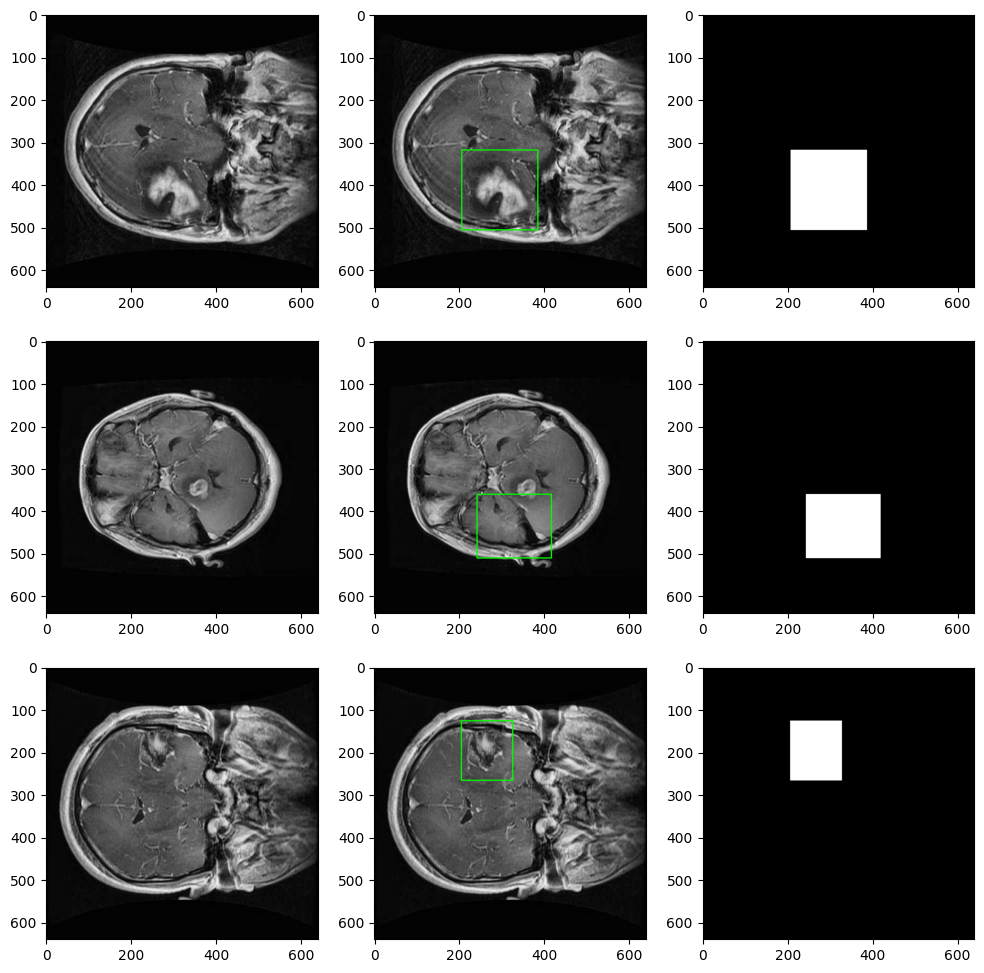

In [13]:
def visualize_random_images(img_dir, n=3): # select n random images

  # use cv and plt to show these images
  indices = np.random.randint(0, len(train_annotation['images']), size=n)

    #Image and Annotation Retrieval:
  images =[train_annotation['images'][i] for i in indices ]
  annotations = [train_annotation['annotations'][i] for i in indices ]

  j=1
  plt.figure(figsize=(12, 4 * n))
  for img,ann in zip(images,annotations):

    plt.subplot(n,3,j)
    j+=1
    image = cv2.imread(os.path.join(img_dir, img['file_name']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # create masked images from annotations
    segmentation = ann['segmentation']
    segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2) #convert 1D into 2D

    cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

    plt.subplot(n,3,j)
    plt.imshow(image)
    j+=1

    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [segmentation], color=1)
    plt.subplot(n,3,j)
    plt.imshow(mask,cmap='gray')
    j+=1

visualize_random_images(train_image_dir)


# Apply mask for all Image

In [14]:
def prepare_masks(img_dir, mask_dir, annotation):
    print(f'{mask_dir.split("/")[-1]} masks')
    os.makedirs(mask_dir, exist_ok=True)
    totalImages = len(annotation['images'])
    done = 0
    for img,ann in zip(annotation['images'],annotation['annotations']):
        path = os.path.join(img_dir, img['file_name'])
        mask_path = os.path.join(mask_dir, img['file_name'])

        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done += 1
        # print(f"{mask_dir.split('/')[-1]}  {done} / {totalImages} ")

In [15]:
threads = []
datasets = [
    (train_image_dir, train_mask_dir, train_annotation),
    (valid_image_dir, valid_mask_dir, valid_annotation),
    (test_image_dir, test_mask_dir, test_annotation),
]

for img_dir, mask_dir, annotation in datasets:
    thread = threading.Thread(target=prepare_masks, args=(img_dir, mask_dir, annotation))
    threads.append(thread)
    thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

print("All mask preparations are complete.")

train masks
valid masks
test masks
All mask preparations are complete.


# Load data

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, mask_dir, annotation, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.annotation = annotation

        self.transform = transform


    def __len__(self):
        return len(self.annotation['images'])

    def __getitem__(self, idx):
        img_info = self.annotation['images'][idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        mask_path = os.path.join(self.mask_dir, img_info['file_name'])

        img = Image.open(img_path).convert('RGB')
        img_gray = img.convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform is not None:
            img_gray = self.transform(img_gray)
            mask = self.transform(mask)

        return img_gray, mask


In [17]:
transform = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

In [18]:
train_dataset = CustomDataset(*datasets[0], transform)
valid_dataset = CustomDataset(*datasets[1], transform)
test_dataset = CustomDataset(*datasets[2], transform)
len(train_dataset), len(valid_dataset), len(test_dataset)

(1502, 429, 215)

In [19]:
train_loader = DataLoader(train_dataset, config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, config.BATCH_SIZE, shuffle=True)
len(train_loader), len(valid_loader), len(test_loader)

(47, 14, 7)

# Model

In [20]:
model = config.BACKBONE

# Training

In [21]:
loss_fn = losses.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)
metrics = [metrics.IoU()]

In [22]:
train_epoch = train.TrainEpoch(
    model=model,
    loss=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    device=config.DEVICE,
)

valid_epoch = train.ValidEpoch(
    model=model,
    loss=loss_fn,
    metrics=metrics,
    device=config.DEVICE,
)

In [23]:
def visualize_input_output_target(input_image, output_image, target_image):
    input_image = input_image.cpu()
    output_image = output_image.cpu()
    target_image = target_image.cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(output_image.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    axes[2].imshow(target_image.squeeze().numpy(), cmap='gray')
    axes[2].set_title('Target Image (Ground Truth)')
    axes[2].axis('off')

    plt.show()
    fig.savefig("output.png")

In [24]:
test_iter = next(iter(test_loader))
X_fixed, y_fixed = test_iter
random_indices = torch.randint(0, 32, (2,))

Epoch 1/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s, bce_with_logits_loss - 0.1306, iou_score - 0.1472]


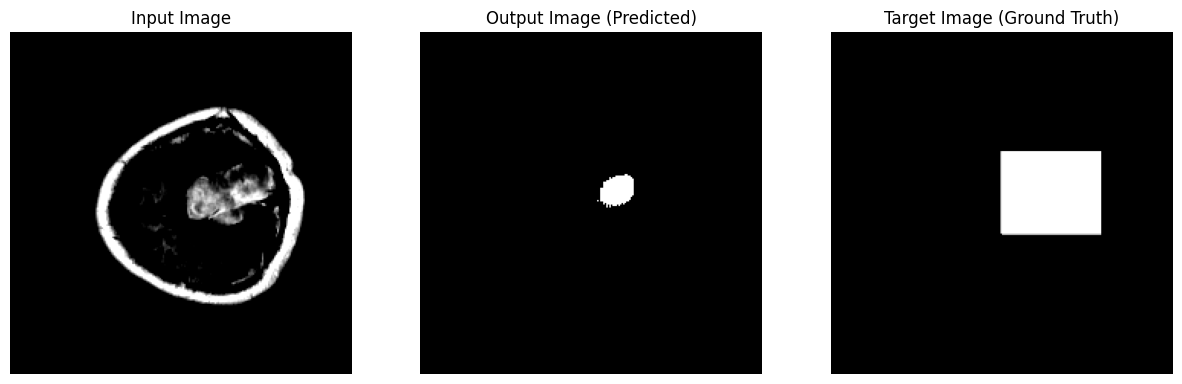

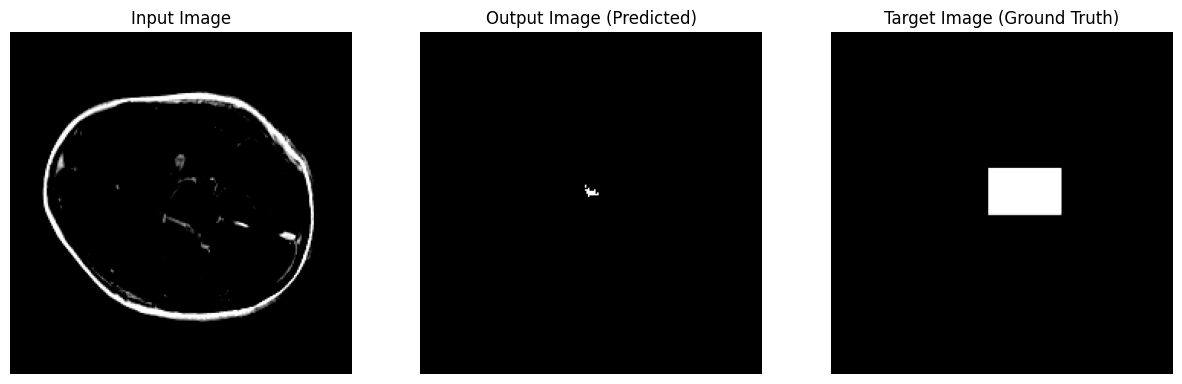

Epoch 2/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.56it/s, bce_with_logits_loss - 0.0943, iou_score - 0.2953]
Epoch 3/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.92it/s, bce_with_logits_loss - 0.0849, iou_score - 0.1048]
Epoch 4/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s, bce_with_logits_loss - 0.08628, iou_score - 0.1187]
Epoch 5/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, bce_with_logits_loss - 0.07895, iou_score - 0.1783]
Epoch 6/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.57it/s, bce_with_logits_loss - 0.07979, iou_score - 0.3063]
Epoch 7/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, bce_with_logits_loss - 0.07365, iou_score - 0.3461]
Epoch 8/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.93it/s, bce_with_logits_loss - 0.07977, iou_score - 0.3117]
Epoch 9/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.61it/s, bce_with_logits_loss - 0.07871, iou_score - 0.2986]
Epoch 10/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2

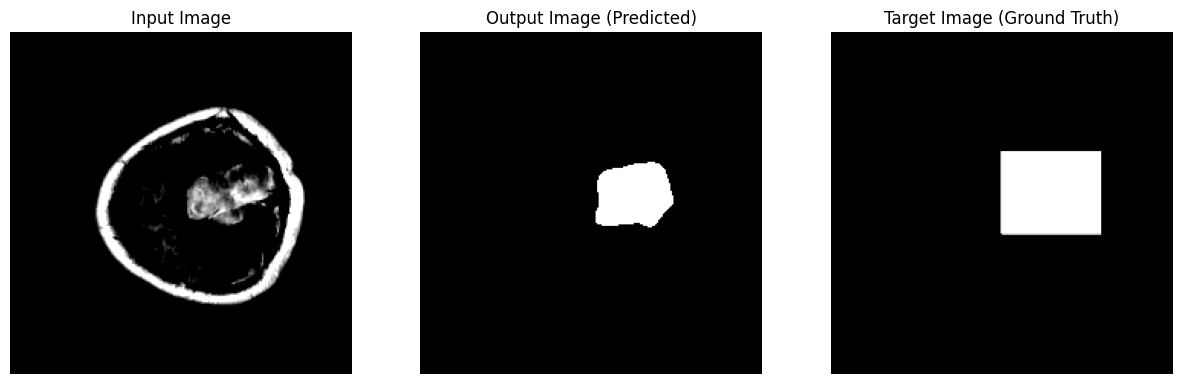

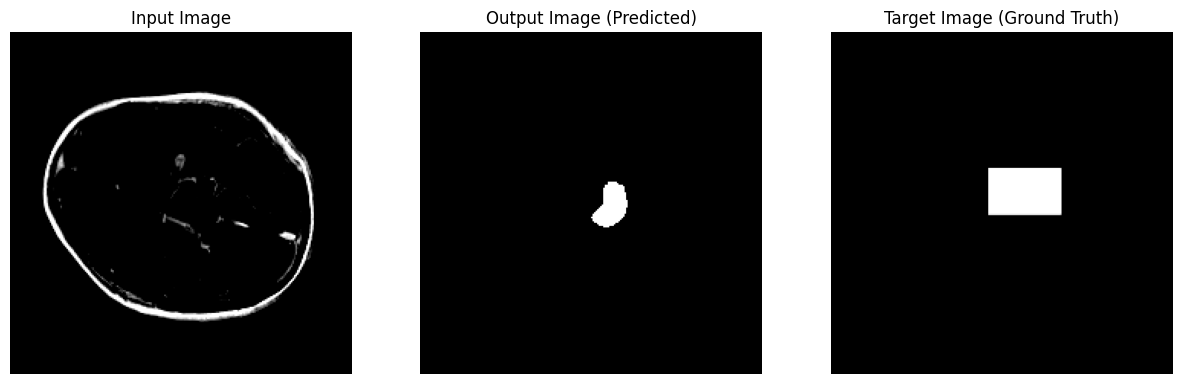

Epoch 12/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s, bce_with_logits_loss - 0.08041, iou_score - 0.3174]
Epoch 13/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s, bce_with_logits_loss - 0.08505, iou_score - 0.3482]
Epoch 14/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s, bce_with_logits_loss - 0.08216, iou_score - 0.3911]
Epoch 15/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s, bce_with_logits_loss - 0.09275, iou_score - 0.3563]
Epoch 16/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.89it/s, bce_with_logits_loss - 0.09013, iou_score - 0.3926]
Epoch 17/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.58it/s, bce_with_logits_loss - 0.07962, iou_score - 0.432]
Epoch 18/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, bce_with_logits_loss - 0.102, iou_score - 0.3178]
Epoch 19/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s, bce_with_logits_loss - 0.0958, iou_score - 0.4023]
Epoch 20/30
valid: 100%|██████████| 14/14 [00:04<00:

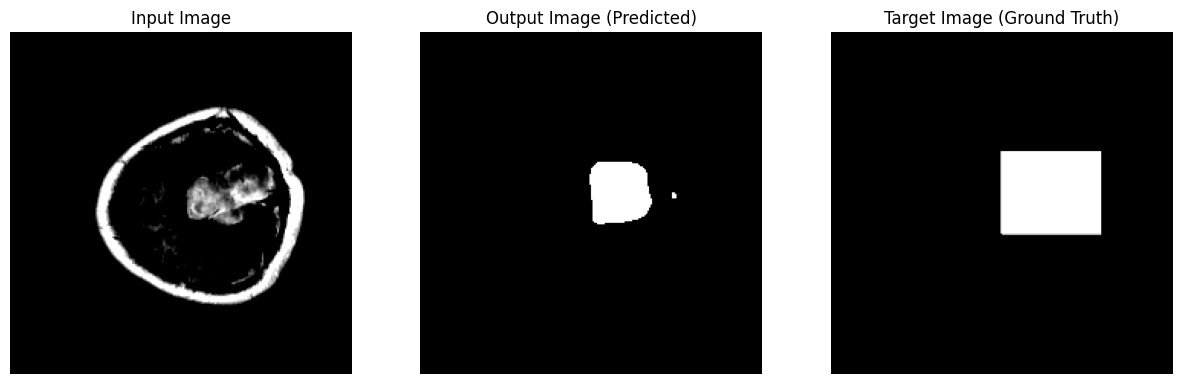

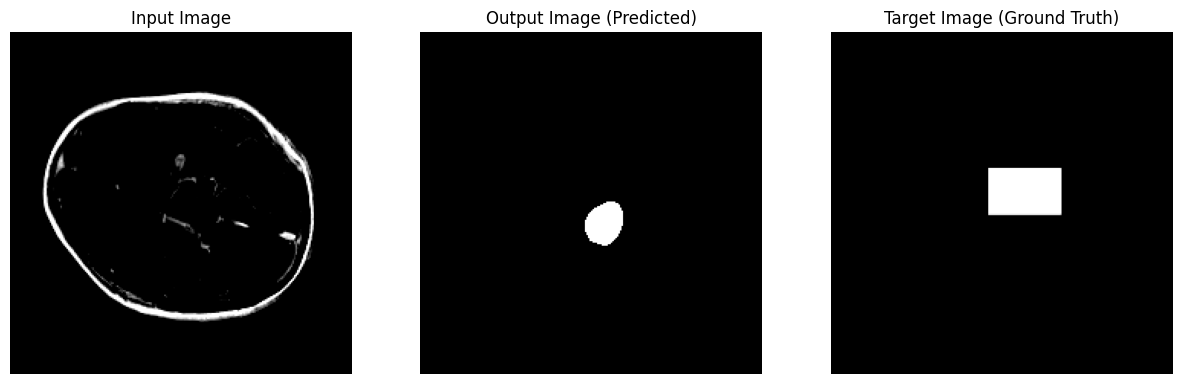

Epoch 22/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, bce_with_logits_loss - 0.1119, iou_score - 0.3441]
Epoch 23/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s, bce_with_logits_loss - 0.102, iou_score - 0.4023]
Epoch 24/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s, bce_with_logits_loss - 0.09655, iou_score - 0.414]
Epoch 25/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s, bce_with_logits_loss - 0.1113, iou_score - 0.4111]
Epoch 26/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.55it/s, bce_with_logits_loss - 0.1144, iou_score - 0.3924]
Epoch 27/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s, bce_with_logits_loss - 0.1156, iou_score - 0.4007]
Epoch 28/30
valid: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s, bce_with_logits_loss - 0.1087, iou_score - 0.4331]
Epoch 29/30
valid: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, bce_with_logits_loss - 0.1263, iou_score - 0.4045]
Epoch 30/30
valid: 100%|██████████| 14/14 [00:05<00:00,  

In [25]:
for epoch in range(config.N_EPOCHS):
  print(f'Epoch {epoch+1}/{config.N_EPOCHS}')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)

  if epoch % 10 == 0:
    with torch.inference_mode():
          X = X_fixed.to(config.DEVICE)
          y = y_fixed.to(config.DEVICE)

          y_pred_logits = model(X)

          y_pred_binary = (y_pred_logits > 0.5).float()

          for idx in random_indices:
              visualize_input_output_target(X[idx], y_pred_binary[idx], y[idx])

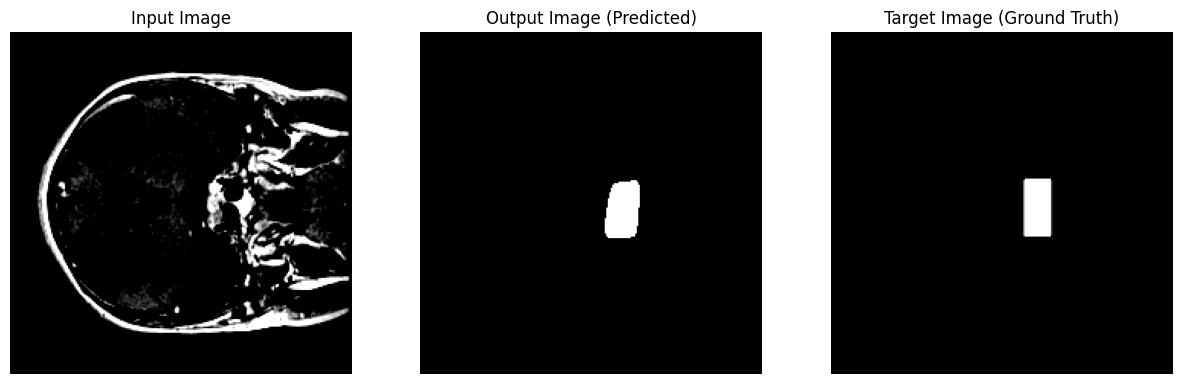

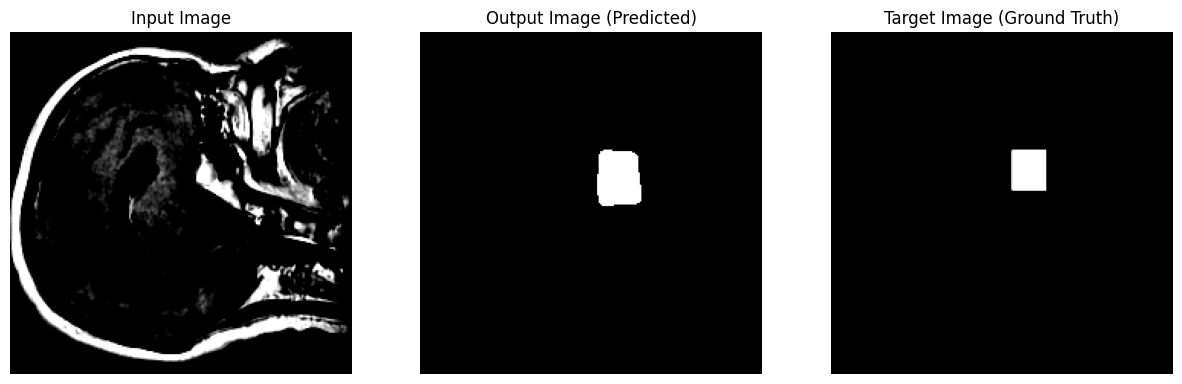

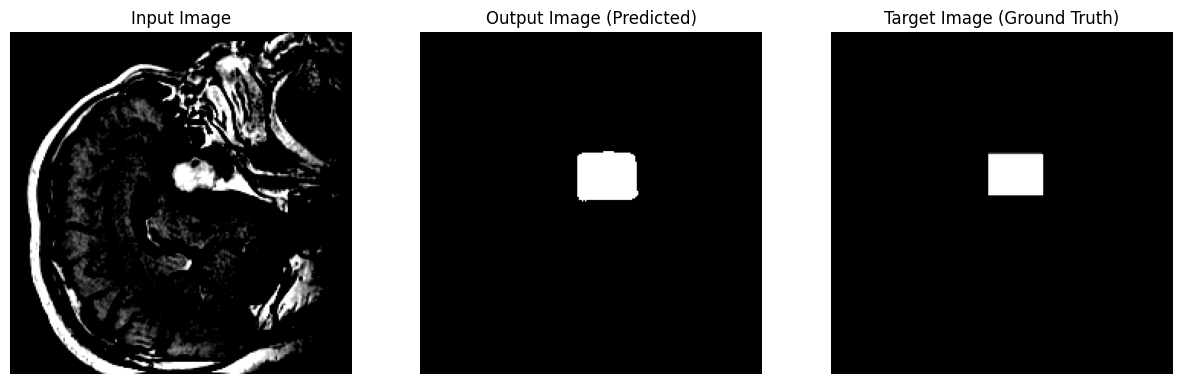

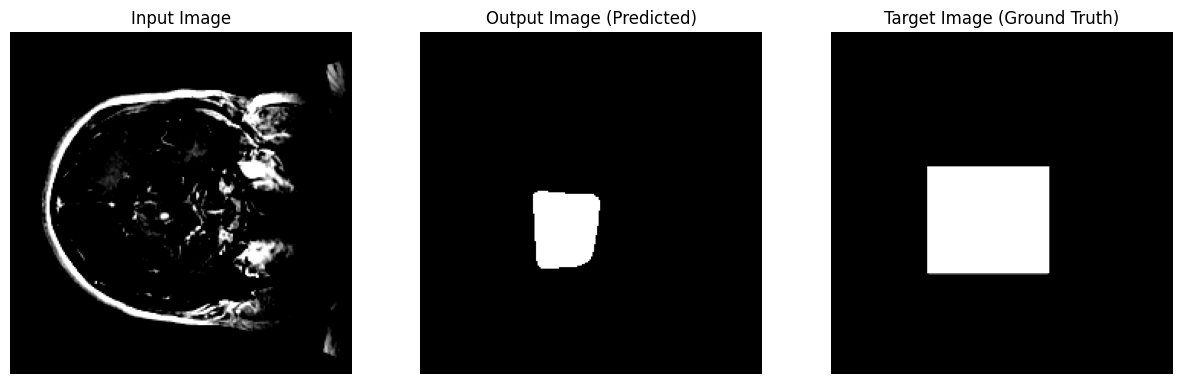

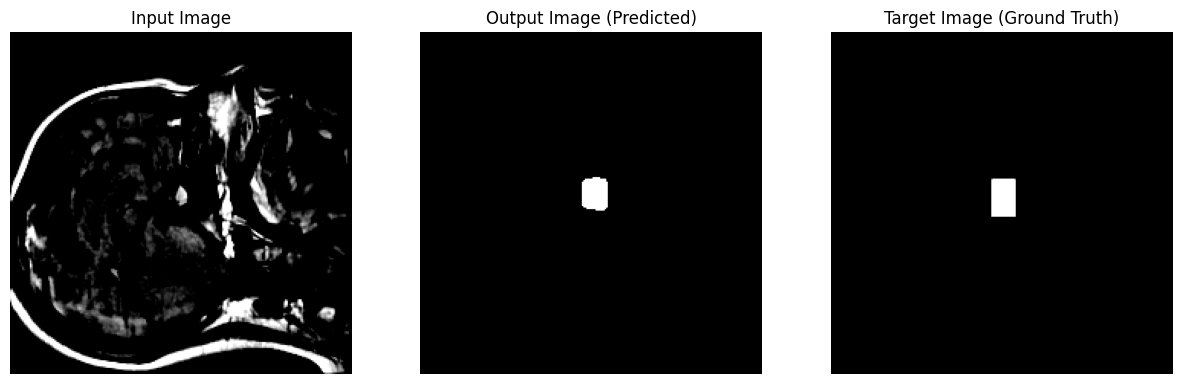

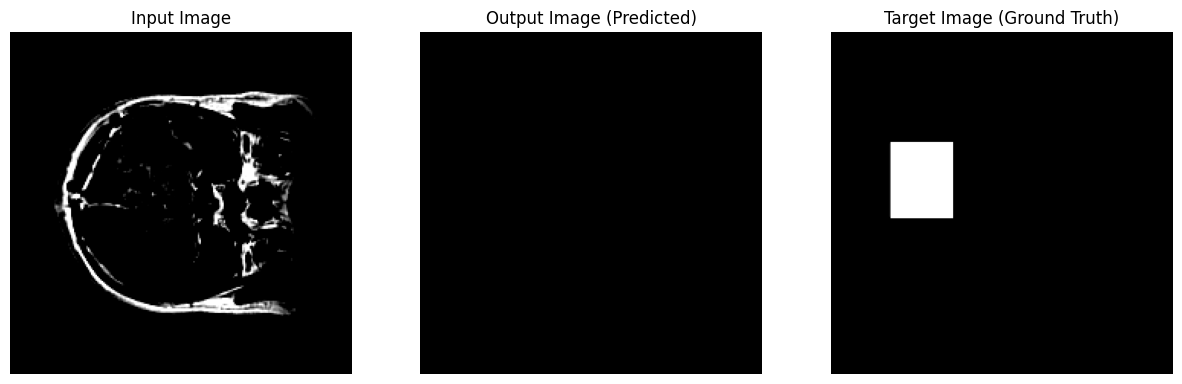

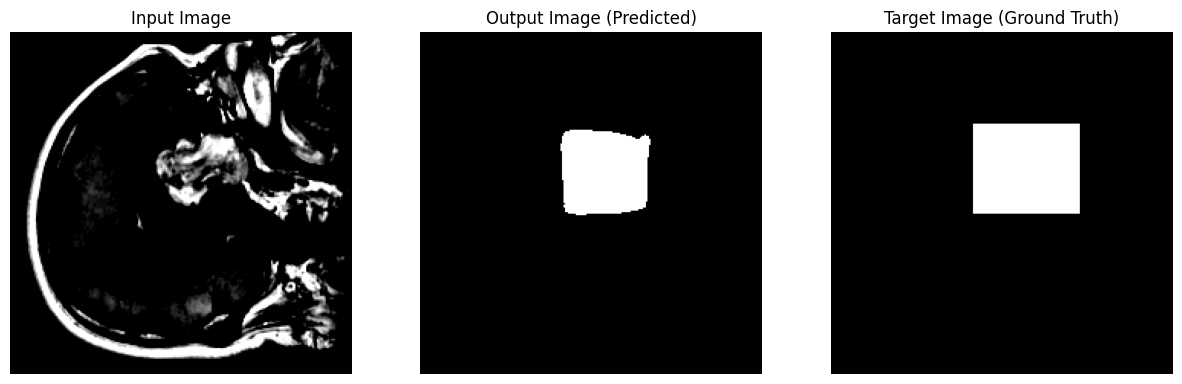

In [30]:
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
        X = X.to(config.DEVICE, dtype=torch.float32)
        y = y.to(config.DEVICE, dtype=torch.float32)

        y_pred_logits = model(X)

        y_pred_binary = (y_pred_logits > 0.5).float()

        visualize_input_output_target(X[0], y_pred_binary[0], y[0])

In [27]:
torch.save(model.state_dict(), 'model.pth')

In [31]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
!cp /content/model.pth /content/drive/MyDrive/Work/br